<a href="https://colab.research.google.com/github/sonjoy2074/Sentence_Contradiction_Classification/blob/main/Sentence_Contradiction_ClassificationV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# prompt: connect with drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertForSequenceClassification


**Load Dataset**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Sentence_Contradiction_ClassificationDataset/train.csv")
print(df.head())

           id                                            premise  \
0  5130fd2cb5  and these comments were considered in formulat...   
1  5b72532a0b  These are issues that we wrestle with in pract...   
2  3931fbe82a  Des petites choses comme celles-là font une di...   
3  5622f0c60b  you know they can't really defend themselves l...   
4  86aaa48b45  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                          hypothesis lang_abv language  label  
0  The rules developed in the interim were put to...       en  English      0  
1  Practice groups are not permitted to work on t...       en  English      2  
2              J'essayais d'accomplir quelque chose.       fr   French      0  
3  They can't defend themselves because of their ...       en  English      0  
4    เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร       th     Thai      1  


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.3+ KB
None


In [ ]:
print(df.isnull().sum())

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64


**Exploratory Data Analysis (EDA)**

Label distribution

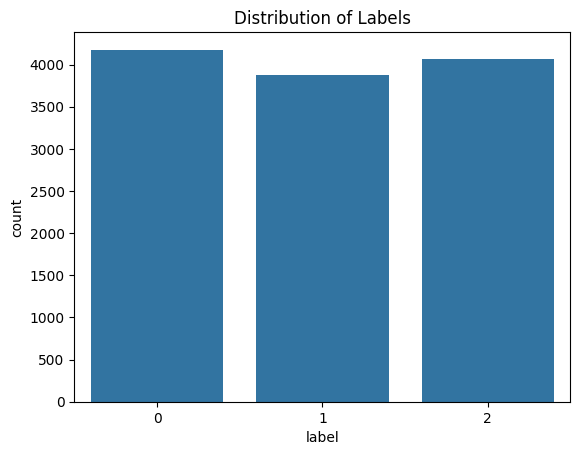

In [ ]:
sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.show()

**Sentence length analysis**

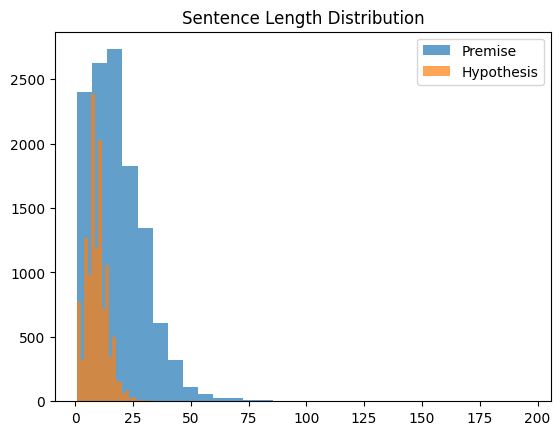

In [ ]:
df['premise_length'] = df['premise'].apply(lambda x: len(str(x).split()))
df['hypothesis_length'] = df['hypothesis'].apply(lambda x: len(str(x).split()))

plt.hist(df['premise_length'], bins=30, alpha=0.7, label="Premise")
plt.hist(df['hypothesis_length'], bins=30, alpha=0.7, label="Hypothesis")
plt.legend()
plt.title("Sentence Length Distribution")
plt.show()

**Language distribution**

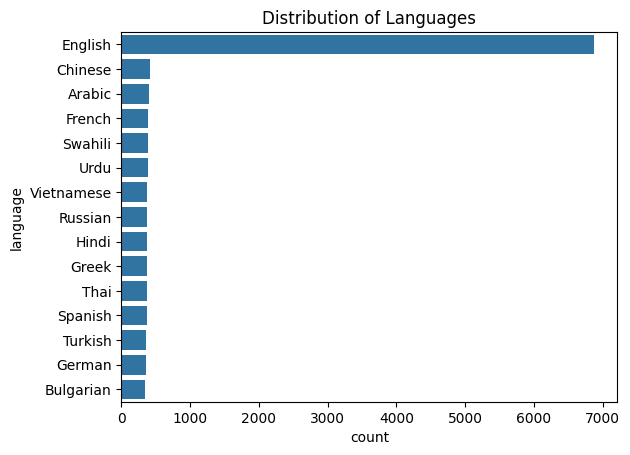

In [ ]:
sns.countplot(y='language', data=df, order=df['language'].value_counts().index)
plt.title('Distribution of Languages')
plt.show()

**Text Preprocessing**

In [ ]:
df['premise'] = df['premise'].str.casefold()
df['hypothesis'] = df['hypothesis'].str.casefold()

**Remove Special Characters and Punctuation**

In [ ]:
import re
def clean_text(text):
    return re.sub(r'[^\w\s]', '', text)

df['premise'] = df['premise'].apply(clean_text)
df['hypothesis'] = df['hypothesis'].apply(clean_text)

In [ ]:
print(df[['premise', 'hypothesis']].head())

                                             premise  \
0  and these comments were considered in formulat...   
1  these are issues that we wrestle with in pract...   
2  des petites choses comme celleslà font une dif...   
3  you know they cant really defend themselves li...   
4  ในการเลนบทบาทสมมตกเชนกน โอกาสทจะไดแสดงออกและได...   

                                          hypothesis  
0  the rules developed in the interim were put to...  
1  practice groups are not permitted to work on t...  
2                 jessayais daccomplir quelque chose  
3   they cant defend themselves because of their age  
4               เดกสามารถเหนไดวาชาตพนธแตกตางกนอยางไร  


**Tokenization(Split sentences into words)**

In [ ]:
df['premise'] = df['premise'].apply(lambda x: x.split())
df['hypothesis'] = df['hypothesis'].apply(lambda x: x.split())

In [ ]:
print(df[['premise', 'hypothesis']].head())

                                             premise  \
0  [and, these, comments, were, considered, in, f...   
1  [these, are, issues, that, we, wrestle, with, ...   
2  [des, petites, choses, comme, celleslà, font, ...   
3  [you, know, they, cant, really, defend, themse...   
4  [ในการเลนบทบาทสมมตกเชนกน, โอกาสทจะไดแสดงออกและ...   

                                          hypothesis  
0  [the, rules, developed, in, the, interim, were...  
1  [practice, groups, are, not, permitted, to, wo...  
2            [jessayais, daccomplir, quelque, chose]  
3  [they, cant, defend, themselves, because, of, ...  
4             [เดกสามารถเหนไดวาชาตพนธแตกตางกนอยางไร]  


**Remove common words like "the", "is", etc., that don't add much meaning**

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
def remove_stopwords(text_tokens, lang):
    try:
        lang_stopwords = set(stopwords.words(lang))  # Get stopwords for the given language
    except:
        lang_stopwords = set(stopwords.words('english'))  # Default to English if unavailable

    return [word for word in text_tokens if word.lower() not in lang_stopwords]

# Apply stopword removal based on the 'lang_abv' column
df['premise'] = df.apply(lambda row: remove_stopwords(row['premise'], row['lang_abv']), axis=1)
df['hypothesis'] = df.apply(lambda row: remove_stopwords(row['hypothesis'], row['lang_abv']), axis=1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(df[['premise', 'hypothesis']].head())

                                             premise  \
0  [comments, considered, formulating, interim, r...   
1  [issues, wrestle, practice, groups, law, firms...   
2  [des, petites, choses, comme, celleslà, font, ...   
3  [know, cant, really, defend, like, somebody, g...   
4  [ในการเลนบทบาทสมมตกเชนกน, โอกาสทจะไดแสดงออกและ...   

                                          hypothesis  
0  [rules, developed, interim, put, together, com...  
1        [practice, groups, permitted, work, issues]  
2            [jessayais, daccomplir, quelque, chose]  
3                                [cant, defend, age]  
4             [เดกสามารถเหนไดวาชาตพนธแตกตางกนอยางไร]  


**Reduce words to their root form (e.g., "running" → "run").**

In [ ]:
from nltk.stem import PorterStemmer, SnowballStemmer

# Initialize English stemmer
porter_stemmer = PorterStemmer()

# Function to get the appropriate stemmer based on language
def get_stemmer(lang):
    try:
        return SnowballStemmer(lang)  # SnowballStemmer supports multiple languages
    except:
        return porter_stemmer  # Default to PorterStemmer for unsupported languages

# Function to apply stemming based on detected language
def stem_words(text_tokens, lang):
    stemmer = get_stemmer(lang)  # Get correct stemmer
    return [stemmer.stem(word) for word in text_tokens]

# Apply stemming based on the 'lang_abv' column
df['premise'] = df.apply(lambda row: stem_words(row['premise'], row['lang_abv']), axis=1)
df['hypothesis'] = df.apply(lambda row: stem_words(row['hypothesis'], row['lang_abv']), axis=1)


In [ ]:
print(df[['premise', 'hypothesis']].head())

                                             premise  \
0           [comment, consid, formul, interim, rule]   
1    [issu, wrestl, practic, group, law, firm, said]   
2  [de, petit, chose, comm, celleslà, font, une, ...   
3  [know, cant, realli, defend, like, somebodi, g...   
4  [ในการเลนบทบาทสมมตกเชนกน, โอกาสทจะไดแสดงออกและ...   

                                          hypothesis  
0  [rule, develop, interim, put, togeth, comment,...  
1               [practic, group, permit, work, issu]  
2              [jessayai, daccomplir, quelqu, chose]  
3                                [cant, defend, age]  
4             [เดกสามารถเหนไดวาชาตพนธแตกตางกนอยางไร]  


**Feature Extraction(using TF-IDF)**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

# Convert lists of tokens into single strings
df['premise'] = df['premise'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['hypothesis'] = df['hypothesis'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)

# Transform the text data
X1 = tfidf.fit_transform(df['premise']).toarray()  # Fit and transform premise
X2 = tfidf.transform(df['hypothesis']).toarray()  # Transform hypothesis

# Concatenate the features
X = np.concatenate((X1, X2), axis=1)
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Random Forest**

Accuracy: 0.24422442244224424
              precision    recall  f1-score   support

           0       0.26      0.27      0.27       851
           1       0.25      0.23      0.24       773
           2       0.22      0.22      0.22       800

    accuracy                           0.24      2424
   macro avg       0.24      0.24      0.24      2424
weighted avg       0.24      0.24      0.24      2424



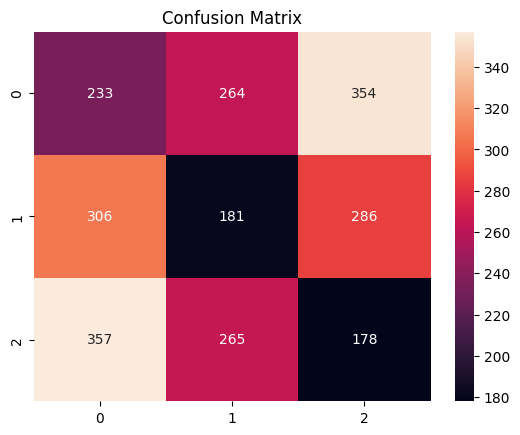

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


**Decision Tree**

Accuracy: 0.32838283828382836
              precision    recall  f1-score   support

           0       0.32      0.36      0.34       851
           1       0.32      0.30      0.31       773
           2       0.34      0.32      0.33       800

    accuracy                           0.33      2424
   macro avg       0.33      0.33      0.33      2424
weighted avg       0.33      0.33      0.33      2424



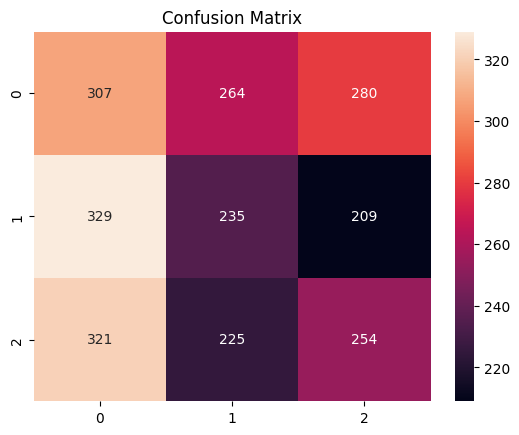

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
# Predictions
y_pred = dt_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

**XGboot**

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:57:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.3803630363036304
              precision    recall  f1-score   support

           0       0.37      0.59      0.46       851
           1       0.36      0.25      0.30       773
           2       0.43      0.28      0.34       800

    accuracy                           0.38      2424
   macro avg       0.39      0.37      0.36      2424
weighted avg       0.39      0.38      0.37      2424



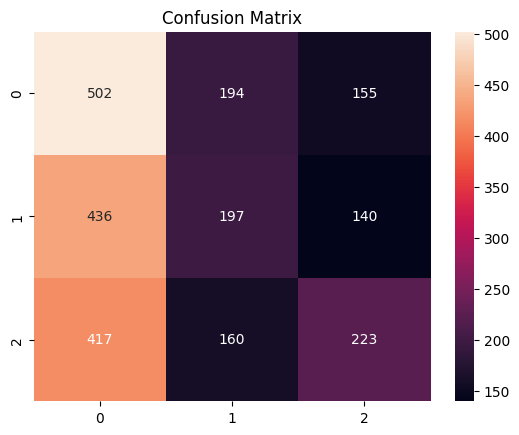

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

**ANN model**

Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3372 - loss: 1.0987 - val_accuracy: 0.3156 - val_loss: 1.0976
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5064 - loss: 1.0338 - val_accuracy: 0.3164 - val_loss: 1.1586
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6859 - loss: 0.7715 - val_accuracy: 0.2962 - val_loss: 1.4195
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8105 - loss: 0.4933 - val_accuracy: 0.2884 - val_loss: 1.9698
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8615 - loss: 0.3262 - val_accuracy: 0.2822 - val_loss: 2.5242
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8968 - loss: 0.2426 - val_accuracy: 0.2855 - val_loss: 2.9556
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9089 - loss: 0.1977 - val_accuracy: 0.2859 - val_loss: 3.2322
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9280 - loss: 0.1620 - val_accuracy: 0.

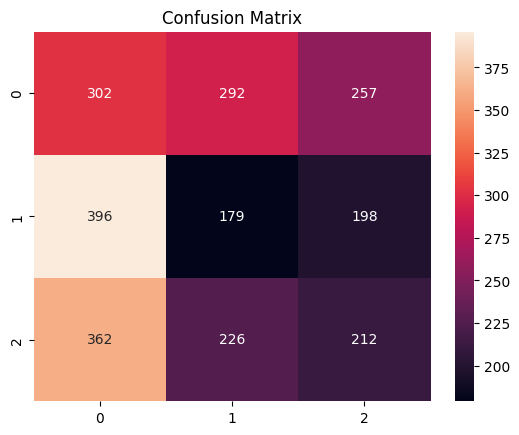

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.decomposition import TruncatedSVD
# ANN model
ann_model = Sequential([
    Dense(128, activation='relu', input_dim=X.shape[1]),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # Assuming 3 classes
])

ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
ann_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predictions
y_pred = np.argmax(ann_model.predict(X_test), axis=1)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

**LSTM Model**

In [ ]:
# Define LSTM model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=X.shape[1]),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 192s 623ms/step - accuracy: 0.3371 - loss: 1.0993 - val_accuracy: 0.3300 - val_loss: 1.0995
Epoch 2/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 195s 601ms/step - accuracy: 0.3352 - loss: 1.0996 - val_accuracy: 0.3511 - val_loss: 1.0979
Epoch 3/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 198s 589ms/step - accuracy: 0.3475 - loss: 1.0980 - val_accuracy: 0.3511 - val_loss: 1.0981
Epoch 4/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 206s 602ms/step - accuracy: 0.3369 - loss: 1.0989 - val_accuracy: 0.3300 - val_loss: 1.0983
Epoch 5/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 182s 601ms/step - accuracy: 0.3391 - loss: 1.0983 - val_accuracy: 0.3511 - val_loss: 1.0981
Epoch 6/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 198s 587ms/step - accuracy: 0.3444 - loss: 1.0981 - val_accuracy: 0.3511 - val_loss: 1.0982
Epoch 7/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 182s 601ms/step - accuracy: 0.3389 - loss: 1.0985 - val_accuracy: 0.3511 - val_loss: 1.0980
Epoch 8/10
303/303 ━━━━━━━━━━━━━━━━━━━━ 198s 588ms/step - accuracy: 0.3521 -

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


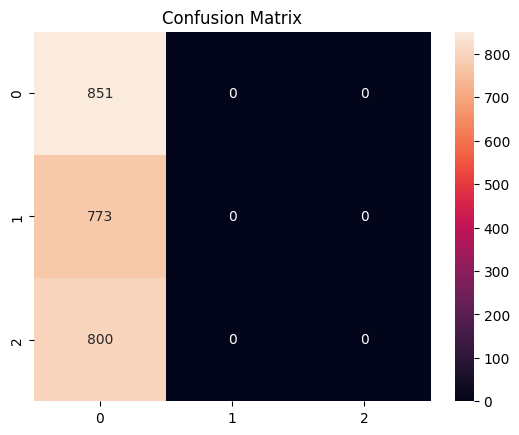

In [ ]:
# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()

**BERT Model**

In [ ]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input texts
def tokenize_data(sentences1, sentences2, tokenizer, max_length=128):
    return tokenizer(sentences1.tolist(), sentences2.tolist(),
                     padding=True, truncation=True, max_length=max_length, return_tensors='tf')

# Convert lists of tokens into single strings
df['premise'] = df['premise'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
df['hypothesis'] = df['hypothesis'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Tokenize the dataset
tokens = tokenize_data(df['premise'], df['hypothesis'], tokenizer)
y = df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tokens, y, test_size=0.2, random_state=42)

# Load pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Define BERT model for classification
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(128,), dtype=tf.int32, name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)[1]  # Use pooled output
x = Dense(128, activation='relu')(bert_output)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
out = Dense(3, activation='softmax')(x)  # Assuming 3 classes

model = Model(inputs=[input_ids, attention_mask], outputs=out)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
    y=y_train,
    epochs=3,
    batch_size=16,
    validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, y_test)
)

# Predictions
y_pred = np.argmax(model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}), axis=1)

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

ValueError: Found input variables with inconsistent numbers of samples: [3, 12120]

In [ ]:
from transformers import BertTokenizer, XLMRobertaTokenizer
import torch
# Choose either BERT or XLM-R tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Tokenize the premise and hypothesis
def tokenize_data(df, tokenizer, max_length=128):
    return tokenizer(
        df['premise'].tolist(),
        df['hypothesis'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Tokenize the dataset
encoded_data = tokenize_data(df, tokenizer)

# Convert labels to tensor
labels = torch.tensor(df['label'].tolist())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'FetchError: Could not fetch resource at https://colab.research.google.com/userdata/get?authuser=1&notebookid=1smigpOCa0NEQ1G1DgR7lL4z3pZT57XSS&key=HF_TOKEN: 401  '.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data
train_idx, test_idx = train_test_split(range(len(df)), test_size=0.2, random_state=42)

# Create datasets
train_dataset = torch.utils.data.TensorDataset(
    encoded_data['input_ids'][train_idx],
    encoded_data['attention_mask'][train_idx],
    labels[train_idx]
)

test_dataset = torch.utils.data.TensorDataset(
    encoded_data['input_ids'][test_idx],
    encoded_data['attention_mask'][test_idx],
    labels[test_idx]
)

In [ ]:
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification

# Choose either BERT or XLM-R model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
# model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from torch.utils.data import DataLoader
from transformers import Trainer, TrainingArguments

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: